70
Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_2D_Release/SEC_Plenum_TurbineBoundary/Plotfiles/Plenum0/plt000000720
(672, 128)
[-0.09  0.1  -0.5   0.5 ]


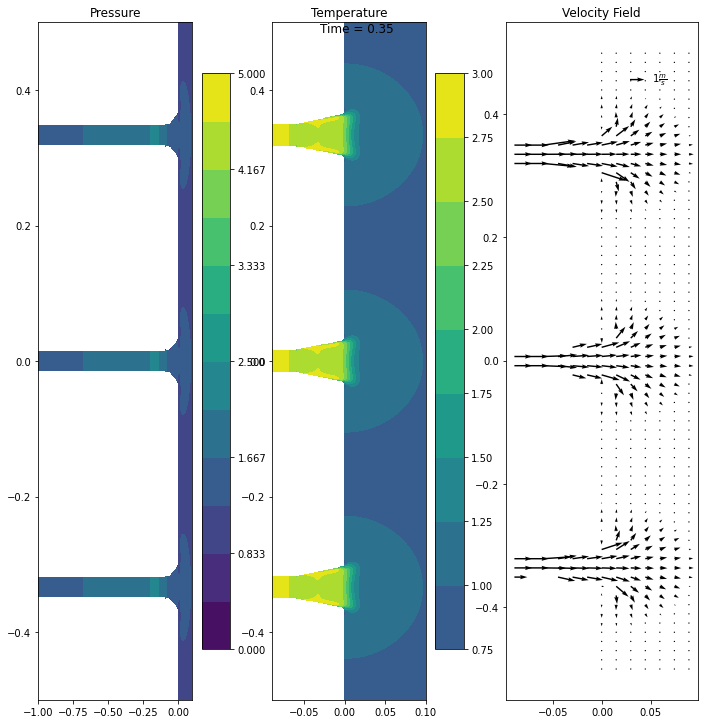

In [73]:
import yt
import os
import numpy as np
import matplotlib.pyplot as plt

valueString = 'Pressure' # which value we want to plot
# possible values are: ['Density', 'Energy', 'Momentum_0', 'Momentum_1', 'Pressure', 'Species_0', 'Species_1', 'SpeedOfSound', 'vfrac']

# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary/"
dataPath = "/home/christian/FVS_develop/FiniteVolumeSolver/build_2D_Release/SEC_Plenum_TurbineBoundary"
plenum_number = 0
MASK_DATA_WITH_VFRAC = True
vfrac_cutoff = 1.0e-14

def loadData(plotfile, vars, MASK_DATA_WITH_VFRAC=True):
  ds = yt.load(plotfile)
  ytplt = yt.plot_2d(ds, vars, origin='native')
  ytplt.set_buff_size((ds.domain_dimensions[0], ds.domain_dimensions[1]))
  ad = ds.all_data()
  current_time = ds.current_time
  datas = [np.squeeze(np.array(ytplt.frb[var])) for var in vars]
  if MASK_DATA_WITH_VFRAC:
    vfrac = np.array(ytplt.frb["vfrac"])
    vfrac = np.squeeze(vfrac)
    datas = [np.ma.masked_where( vfrac<=vfrac_cutoff, data, np.nan) for data in datas]
  return datas, current_time, np.array(ytplt.bounds)

def PrintProgress(i, plotfiles):
  ny = len(plotfiles)
  progress = int(100.0 * float(i) / (ny - 1))
  print('[{:3d}%] Reading plotfile {}'.format(progress, plotfiles[i]))

yt.funcs.mylog.setLevel(50)
output_dir = dataPath+'/Plotfiles/Plenum%i'%(plenum_number)

dirs = os.listdir(output_dir)
plotfiles = ['{}/{}'.format(output_dir, plt) for plt in dirs]
list.sort(plotfiles)
plotfiles = plotfiles[:]

output_path = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Pressure")
os.makedirs(output_path, exist_ok=True)

output_path_quiv = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Quiver")
os.makedirs(output_path_quiv, exist_ok=True)

output_path_temp = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Temperature")
os.makedirs(output_path_temp, exist_ok=True)

print(len(plotfiles))
nr=35
for i, plotfile in enumerate(plotfiles[nr:nr+1]):
   #PrintProgress(i, plotfiles)
   print('Reading plotfile {}'.format(plotfile))

   # get Tube Data
   temp = plotfile.split("/")[-1]
   Tubes = [0,1,2]
   
   Tube_p = []
   Tube_rho = []
   Tube_c = []
   extent_tube = []
   
   for tube_number in Tubes:
      Tube_Dir = dataPath+'/Plotfiles/Tube%i/'%tube_number
      (p_tube, rho_tube, c_tube), current_time, extent_temp = loadData(Tube_Dir+temp, ["Pressure", "Density", "SpeedOfSound"], False)
   
      Tube_p.append(p_tube)
      Tube_rho.append(rho_tube)
      Tube_c.append(c_tube)
      extent_tube.append(extent_temp)
   
   
   def stackTubeDataTo2D(Tube_datalist):
     # all Tubedata is 1D but for contourf we need at least 2D data. so simply stack twice the 1d array
     for i, el in enumerate(Tube_datalist):
        Tube_datalist[i] = np.stack((el,el))
     return Tube_datalist
   
   Tube_p = stackTubeDataTo2D(Tube_p)
   Tube_rho = stackTubeDataTo2D(Tube_rho)
   

   # get Plenum data
   (p, rho, rhou, rhov, c), current_time, extent = loadData(plotfile, ["Pressure", "Density", "Momentum_0", "Momentum_1", "SpeedOfSound"])

   nlevel = 13
   vmin = 0.
   vmax = 5.0

   #f, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
   f, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
   f.suptitle('Time = {:.2f}'.format(float(current_time)))
   
   levels = np.linspace(vmin, vmax, nlevel)
   # pressure image
   im_p = axs[0].contourf(p, extent=extent, interpolation='none', levels=levels)
   
   for i, el in enumerate(Tube_p):
      axs[0].contourf(el, extent=extent_tube[i], interpolation='none', aspect='auto', levels=levels)
   
   #axs[0].imshow(p, origin='lower', vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   axs[0].set_aspect('auto')
   plt.tight_layout()
   axs[0].set_title('Pressure')
   plt.colorbar(im_p, ax=axs[0])
   # temperature image
   T = p / rho
   print(T.shape)
   im_T = axs[1].contourf(T, vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   #im_T = axs[1].contourf(X, Y, T, interpolation='none', vmin=vmin, vmax=vmax)
   #im_T2 = axs[1].contourf(X_tube, Y_tube, p_tube / rho_tube, interpolation='none',  aspect='auto',vmin=vmin, vmax=vmax)
   axs[1].set_title('Temperature')
   #axs[1].set(ylim=(extent[2], -0.2))
   plt.colorbar(im_T, ax=axs[1])
   ## velocity field
   u = rhou / rho
   v = rhov / rho
   print(extent)
   skip = 10
   x = np.linspace(*extent[0:2], num=u.shape[1], endpoint=True)
   y = np.linspace(*extent[2:], num=u.shape[0], endpoint=True)
   X,Y = np.meshgrid(x,y)
   #print(x,y)
   scale = 5.0
   Q=axs[2].quiver(X[::skip,::skip], Y[::skip,::skip], u[::skip,::skip], v[::skip,::skip],scale=scale, units='inches', width=0.02)
   axs[2].quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
   axs[2].set_title('Velocity Field')
   plt.show()
   f.savefig(output_path+"/"+temp+".png")
   f.clf()